### Run trained model on test data and visualize

In [1]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import resize
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from PIL import Image, ImagePalette
NUCLEI_PALETTE = ImagePalette.random()

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Name experiment
experiment_name = "exp-1"
        
# Define paths
dataset_name = "test_images" 
base_path = os.path.abspath(".")
test_dataset_path = os.path.join(base_path, "dataset", dataset_name)
log_path = os.path.join(base_path, "logs", experiment_name)
print(test_dataset_path)

Using TensorFlow backend.


/home/hasib/MoNuSAC-ISBI-2020/dataset/test_images


In [2]:
model = None
model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
#model.summary()

In [3]:
def pad(img, pad_size=96):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 96 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]



def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (patch_size[0], patch_size[1]):

            # Resize to 64x64
            #patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            
            
            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches
    
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

In [4]:
# SAME CODE BLOCK AS IN 6_inference.ipynb

import numpy as np
from skimage.transform import resize

# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(18, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
    
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = resize(img, (image_cols, image_rows), preserve_range=True)
    return img




def visualize_results(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)


    
def vis_gray(image, mask):
    
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')



def predict(im):
    """Predict on patch"""
    
    im = np.expand_dims(im, axis=0)
    
    im = model.predict(im)
    im = np.argmax(im.squeeze(), axis=-1)
 
    #assert im.shape == (96, 96), "Wrong shape, {}!".format(im.shape)
    
    return im



def instance_seg(image):
    distance = ndi.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=image)
    return labels    



def whole_slide_predict(whole_image):
    
    #import pdb; pdb.set_trace()
    
    # If input image less than patch, infer on whole image
    if whole_image.shape[0] < 96 or whole_image.shape[1] < 96:
        
        # Get size
        raw_dim = (whole_image.shape[1], whole_image.shape[0]) # W, H
        
        # Resize to 64x64 for prediction
        #whole_image_rs = cv2.resize(whole_image, (64, 64), interpolation = cv2.INTER_AREA)
        whole_image_rs, pad_locs = pad(whole_image, pad_size=96)
        
        
        # Infer
        pred = predict(whole_image_rs)
        
        
        # Resize back to original shape
        #pred = cv2.resize(pred, raw_dim, interpolation = cv2.INTER_AREA)
        pred = unpad(pred, pad_locs)
        
        # Change dtype for resizing back to original shape
        pred = pred.astype(np.uint8)
        
      
    else:
        
        # Get patch locations
        x_pos, y_pos, cells = sliding_window(whole_image, 96, (96, 96)) 

        # Array for storing predictions
        pred = np.zeros((whole_image.shape[0], whole_image.shape[1])).astype(np.uint8)

        # Slide over each patch
        for (x, y, cell) in zip(x_pos, y_pos, cells):

            # Get patch
            patch = whole_image[y:y + 96, x:x + 96]

            # Get size
            raw_dim = (patch.shape[1], patch.shape[0]) # W, H

            # If less than patch size, resize and then run prediction
            if raw_dim != (96, 96):


                # Resize to 64x64
                #patch_rs = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
                patch_rs, pad_locs = pad(patch, pad_size=96)
                
                #print(patch.dtype, processed.dtype)
                
                assert patch.dtype == patch_rs.dtype, "Wrong data type after resizing!"

                
                # Infer
                processed = predict(patch_rs)
                
                # Resize back to original shape
                #processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
                processed = unpad(processed, pad_locs)
                
                # Change dtype 
                processed = processed.astype(np.uint8)
                
                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"

            else:

                
                # Infer
                processed = predict(patch)
                
                # Change dtype
                processed = processed.astype(np.uint8)

                #print(patch.dtype, processed.dtype)
                

                assert patch.shape[:2] == processed.shape, "Wrong shape!"
                assert patch.dtype == processed.dtype, "Wrong data type in prediction!"


            # Add in image variable
            pred[y:y + 96, x:x + 96] = processed 
            processed = None

    return pred


### Run inference on a random single image

Index:  87
Image shape: (293, 341, 3)
uint8
(293, 341, 3) (293, 341)
Uniques predicted [0 1 2 3]


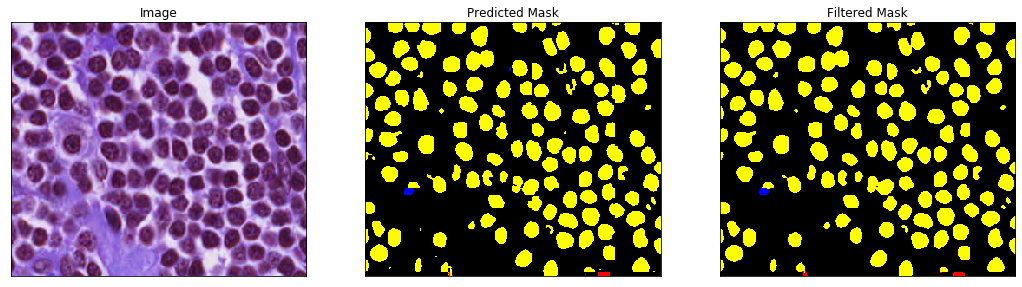

In [7]:
image_fns = sorted(next(os.walk(test_dataset_path))[2])

idx = random.randrange(len(image_fns))
print("Index: ",idx)

image = skimage.io.imread(os.path.join(test_dataset_path, image_fns[idx]))
print("Image shape:", image.shape)

pred = whole_slide_predict(image)
print(pred.dtype)

# Post processing to refine predictions
pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

print(image.shape, pred.shape)
print("Uniques predicted", np.unique(pred))
assert image.shape[:2] == pred.shape, "Image missmatch"

#visualize_results(image, pred)

visualize(
        image=image,
        Predicted_mask = pred,
        Filtered_mask = pred_filt
    )

In [ ]:
#inst_mask = instance_seg(pred_filt)
#print(inst_mask.shape)

#im = Image.fromarray(inst_mask.astype(np.uint8), mode='P')
#im.putpalette(NUCLEI_PALETTE)
#im

In [ ]:
# Dummy mask
zero_mask = np.zeros((pred_filt.shape[0], pred_filt.shape[1])).astype(np.uint8)
# Overlay target class
epi_mask = np.where(pred_filt != 1, zero_mask, 1)
lym_mask = np.where(pred_filt != 2, zero_mask, 2)
neu_mask = np.where(pred_filt != 3, zero_mask, 3)
macro_mask = np.where(pred_filt != 4, zero_mask, 4)

# Get uniques for (debugging)
print(epi_mask.shape, lym_mask.shape, neu_mask.shape, macro_mask.shape)


# Get instances for each class using watershed
epi_mask = instance_seg(epi_mask)
lym_mask = instance_seg(lym_mask)
neu_mask = instance_seg(neu_mask)
macro_mask = instance_seg(macro_mask)
print(epi_mask.shape, lym_mask.shape, neu_mask.shape, macro_mask.shape)



# Add color to instances
epi_mask = Image.fromarray(epi_mask.astype(np.uint8), mode='P')
epi_mask.putpalette(NUCLEI_PALETTE)

lym_mask = Image.fromarray(lym_mask.astype(np.uint8), mode='P')
lym_mask.putpalette(NUCLEI_PALETTE)

neu_mask = Image.fromarray(neu_mask.astype(np.uint8), mode='P')
neu_mask.putpalette(NUCLEI_PALETTE)

macro_mask = Image.fromarray(macro_mask.astype(np.uint8), mode='P')
macro_mask.putpalette(NUCLEI_PALETTE)

In [ ]:
def visualize_inst(**images):
    """Plot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(30, 24))
    for i, (name, image) in enumerate(images.items()):
        
        if name == "GT_mask" or name == "Predicted_mask":
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image, cmap=map_name, norm=norm)
        else:
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
    
    plt.savefig("others/result2.png", bbox_inches = 'tight', pad_inches = 0.2, dpi=300)
    plt.show()
    
    
visualize_inst(
        image=image,
        #GT_mask = gt,
        Predicted_mask = pred_filt,
        Epithelial_mask = epi_mask,
        Lymphocyte_mask = lym_mask,
        Macrophage_mask = neu_mask,
        Neutrophil_mask = macro_mask)

### Infer all test images

In [ ]:
for i in tqdm(range(len(image_fns[:]))):

    image = skimage.io.imread(os.path.join(test_dataset_path, image_fns[i]))

    pred = whole_slide_predict(image)

    #visualize_results(image, pred)
    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pred.astype(np.uint8), 5)

    print(image.shape, pred.shape)
    print("Uniques predicted", np.unique(pred))
    
    visualize(
        image=image,
        Predicted_mask = pred,
        Filtered_mask = pred_filt
    )
    
    assert image.shape[:2] == pred.shape, "Image missmatch"

In [ ]:
from pynotify import send_email, send_email_with_attachment

subject = "Experiment results"
message = "Done!"

dest = "hasibzunair@gmail.com" 

# sends an email
send_email(dest, subject, message)